In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from zipfile import ZipFile
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import ModelCheckpoint

In [5]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

In [6]:
from PIL import Image
print(Image.__file__)

c:\Users\LEGION\anaconda3\envs\python310\lib\site-packages\PIL\Image.py


In [7]:
import Image
print(Image.__file__)

c:\Users\LEGION\anaconda3\envs\python310\lib\site-packages\PIL\Image.py


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input


datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [41]:
# train_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\Augmented"
# # train_dir = '/content/drive/MyDrive/Colab Skripsi/DATASETNEW/2_Augmented'
# # val_dir = '/content/drive/MyDrive/Colab Skripsi/DATASETNEW/2_Split/val'
# # test_dir = '/content/drive/MyDrive/Colab Skripsi/DATASETNEW/2_Split/test'


train_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\SPLIT_TRAINDATA\train"
val_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\SPLIT_TRAINDATA\val"
test_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\SPLIT_TRAINDATA\test"

In [42]:
import json
train_generator = datagen.flow_from_directory(
    train_dir,
    # subset='training',
    target_size=(300, 300),
    batch_size=40,
    class_mode='categorical'
)
class_indices = train_generator.class_indices  # Get class-to-index mapping

# Save the mapping for later use
with open("class_indices.json", "w") as f:
    json.dump(class_indices, f)

Found 20422 images belonging to 4 classes.


In [12]:
val_generator = datagen.flow_from_directory(
    val_dir,
    # subset='validation',
    target_size=(300, 300),
    batch_size=40,
    class_mode='categorical'
)

Found 5834 images belonging to 4 classes.


In [13]:
test_generator = datagen.flow_from_directory(
    test_dir,
    # subset='validation',
    target_size=(300, 300),
    batch_size=40,
    class_mode='categorical'
)

Found 2922 images belonging to 4 classes.


In [14]:
print(len(train_generator))
print(len(val_generator))
print(len(test_generator))

511
146
74


In [15]:
# jadi ini modelnya kek gausah bikin dari nol lagi tapi pake arsitektur yang udah ada

from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model

# SET DIMENSI INPUTNYA
img_rows, img_cols = 300, 300

# model learningnya based on imagenet dataset jadi weightnya set ke imagenet
# top layer diganti soalnya outputnya ada 20k neuron, tapi kita cuma butuh 4 neuron soalnya outputnya kan cuma 4
# ini download model yang udah ada jadi pake model efficientnetb3
resnet = ResNet50(weights = "imagenet",
                  include_top = False,
                  input_shape = (img_rows, img_cols, 3))

# Ngefreeze 4 layer terkahir
# Layers yang di set ke trainable defaultnya True

# for layer in efficientnet.layers:
#   layer.trainable = False

# ini coba freeze semua layer selain 10 layer terakhir
for layer in resnet.layers[:-10]: 
    layer.trainable = False


# ngeprint semua layernya
for (i, layer) in enumerate(resnet.layers):
  print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 Conv2D False
11 BatchNormalization False
12 Activation False
13 Conv2D False
14 Conv2D False
15 BatchNormalization False
16 BatchNormalization False
17 Add False
18 Activation False
19 Conv2D False
20 BatchNormalization False
21 Activation False
22 Conv2D False
23 BatchNormalization False
24 Activation False
25 Conv2D False
26 BatchNormalization False
27 Add False
28 Activation False
29 Conv2D False
30 BatchNormalization False
31 Activation False
32 Conv2D False
33 BatchNormalization False
34 Activation False
35 Conv2D False
36 BatchNormalization False
37 Add False
38 Activation False
39 Conv2D False
40 BatchNormalization False
41 Activation False
42 Conv2D False
43 BatchNormalization False
44 Activation False
45 Conv2D False
46 Conv2D False
47 BatchNormalization False
48 BatchNor

In [16]:
# tambahin beberapa layer ke model itu tadi

# def lw(bottom_model, num_classes):
#   """"creates the top or head of the model that will be
#   placed ontop of the bottom layers"""

#   top_model = bottom_model.output
#   top_model = GlobalAveragePooling2D()(top_model)
#   top_model = Dense(1024,activation="relu")(top_model)
#   top_model = Dense(1024,activation="relu")(top_model)
#   top_model = Dense(512,activation="relu")(top_model)
#   top_model = Dense(num_classes,activation='softmax')(top_model) #last output layer, number of classes = 4
#   return top_model

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(512, activation="relu")(top_model)
    top_model = Dense(256, activation="relu")(top_model)
    top_model = Dropout(0.5)(top_model)  # Dropout buat mencegah overfitting
    top_model = Dense(num_classes, activation='softmax')(top_model)  
    return top_model


In [17]:
# itu tadi udah dibikin function lw nya, secara function lwnya di call

# jumlah class nya 2 soalnya yes sama no
num_classes = 4

FC_Head = lw(resnet, num_classes)

model = Model(inputs = resnet.input, outputs = FC_Head)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 306, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [18]:
# compile modelnya
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
# model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])


# Set learning rate
learning_rate = 0.0005
optimizer = Adam(learning_rate=learning_rate)

# Compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [19]:
# training mulai
filepath=r'D:\PROJECT\SKRIPSI\skripsi_resnet50_0005_augment_1.model.keras'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=(val_generator),
                    initial_epoch=0,
                    callbacks=[checkpoint])


# # training mulai

# history = model.fit(train_generator,
#                     epochs=10,
#                     validation_data=(val_generator),
#                     verbose = 1,
#                     initial_epoch=0)

Epoch 1/20
511/511 [==============================] - ETA: 0s - loss: 0.2479 - accuracy: 0.9078 - precision: 0.9264 - recall: 0.8918
Epoch 1: val_accuracy improved from -inf to 0.92115, saving model to D:\PROJECT\SKRIPSI\skripsi_resnet50_0005_augment_1.model.keras
511/511 [==============================] - 368s 695ms/step - loss: 0.2479 - accuracy: 0.9078 - precision: 0.9264 - recall: 0.8918 - val_loss: 0.2042 - val_accuracy: 0.9212 - val_precision: 0.9285 - val_recall: 0.9153
Epoch 2/20
511/511 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9564 - precision: 0.9624 - recall: 0.9514
Epoch 2: val_accuracy improved from 0.92115 to 0.96263, saving model to D:\PROJECT\SKRIPSI\skripsi_resnet50_0005_augment_1.model.keras
511/511 [==============================] - 186s 364ms/step - loss: 0.1180 - accuracy: 0.9564 - precision: 0.9624 - recall: 0.9514 - val_loss: 0.1014 - val_accuracy: 0.9626 - val_precision: 0.9657 - val_recall: 0.9616
Epoch 3/20
511/511 [=============

In [20]:
# SAVE MODEL
save_path = r"D:\PROJECT\SKRIPSI\skripsi_resnet50_0005_augment_1.h5"
model.save(save_path)

In [21]:
# SAVE MODEL
weights_path = r"D:\PROJECT\SKRIPSI\skripsi_resnet50_0005_augment_1_weights.h5"
model.save_weights(weights_path)

EVALUASI

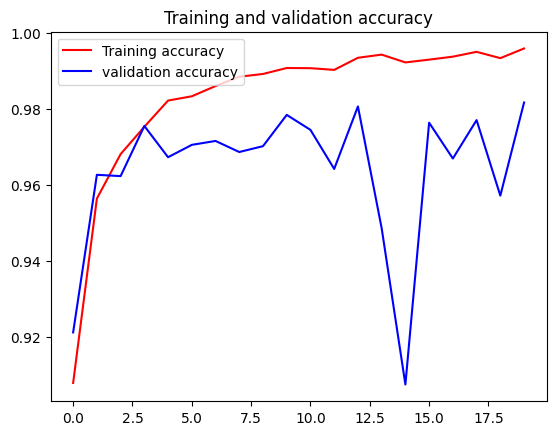

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='upper left')
plt.figure()

plt.show()

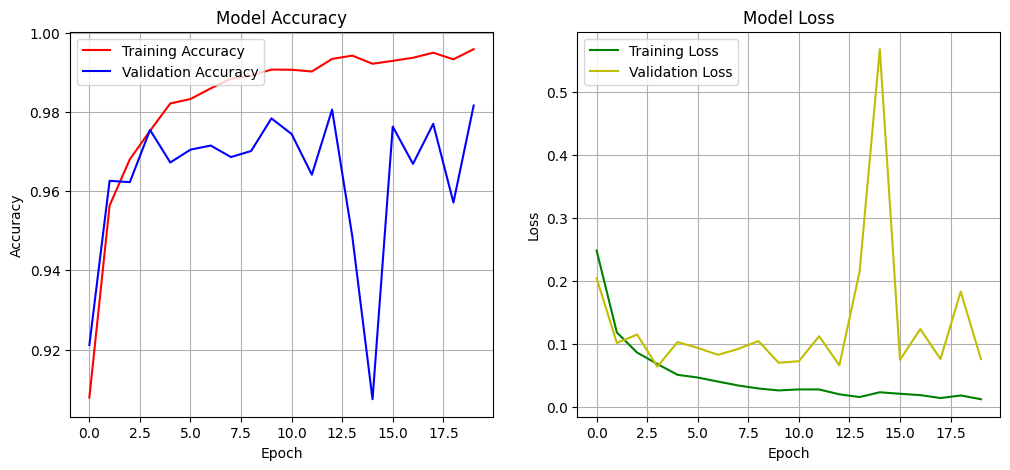

In [23]:
# Grafik plot value accuracy training sama validation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, 'r', label='Training Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Grafik plot value loss training sama validation
plt.subplot(1, 2, 2)
plt.plot(loss, 'g', label='Training Loss')
plt.plot(val_loss, 'y', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()

In [25]:
from tensorflow import keras

model = keras.models.load_model("skripsi_resnet50_0005_augment_1.h5")



In [26]:
test_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\SPLIT_TRAINDATA\test"

In [27]:
import numpy as np
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

img_size = (300, 300)
batch_size = 40

# test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical", 
    shuffle=False
)

true_labels = test_generator.classes


Found 2922 images belonging to 4 classes.


In [29]:
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)


74/74 [==============================] - 54s 692ms/step


In [30]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, pred_labels)

print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[861  10   0  11]
 [  6 851   0   3]
 [  3   1 714   0]
 [ 12   2   0 448]]


In [31]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# label class
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_labels, digits=4))

# akurasi
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1score = f1_score(true_labels, pred_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1score:.4f}")


Classification Report:
              precision    recall  f1-score   support

   EarlyPreB     0.9762    0.9762    0.9762       882
        PreB     0.9850    0.9895    0.9872       860
        ProB     1.0000    0.9944    0.9972       718
      benign     0.9697    0.9697    0.9697       462

    accuracy                         0.9836      2922
   macro avg     0.9827    0.9825    0.9826      2922
weighted avg     0.9836    0.9836    0.9836      2922

Accuracy: 0.9836
Precision: 0.9836
Recall: 0.9836
F1 Score: 0.9836


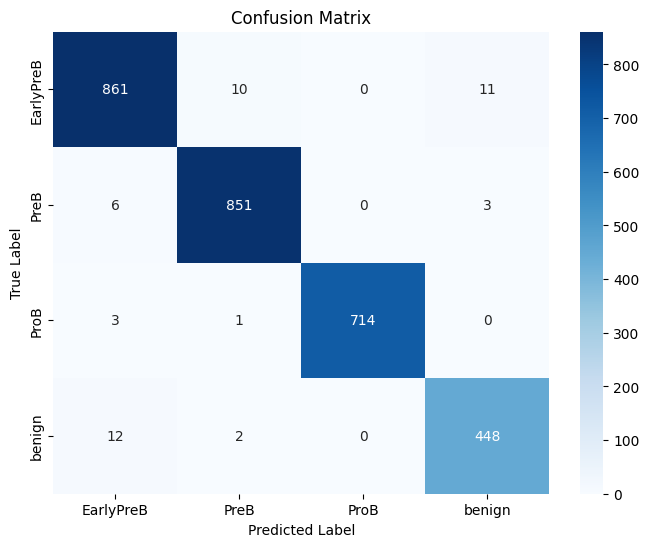

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


HEATMAP

CEK URUTAN CLASS

In [205]:
import json

model = tf.keras.models.load_model("skripsi_resnet50_0005_augment_1.h5")


with open("class_indices.json", "r") as f:
    class_indices = json.load(f)

# Reverse the dictionary to get labels from indices
class_labels = {v: k for k, v in class_indices.items()}

print(class_labels)



{0: 'EarlyPreB', 1: 'PreB', 2: 'ProB', 3: 'benign'}


PREDICTION

In [216]:
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
img = cv2.imread('aaabenign.jpg')
img = cv2.resize(img, (300, 300))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
X = np.expand_dims(img, axis=0).astype(np.float32)
X = preprocess_input(X)

In [217]:
import tensorflow as tf
import numpy as np
import cv2

model = tf.keras.models.load_model("skripsi_resnet50_0005_augment_1.h5")

class_labels = ["EarlyPreB", "PreB", "ProB", "benign"]
model = keras.models.load_model("skripsi_resnet50_0005_augment_1.h5")
conv_output = model.get_layer("conv5_block3_out").output  # Last conv layer
pred_output = model.get_layer("dense_2").output
heatmap_model = Model(inputs=model.input, outputs=[conv_output, pred_output])
heatmap_model.summary()





Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 306, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [218]:
conv, pred = heatmap_model.predict(X)
pred_class_idx = np.argmax(pred, axis=1)[0]
predicted_label = class_labels[pred_class_idx]

print(f"Hasil prediksi class adalah: {predicted_label}")

1/1 [==============================] - 2s 2s/step
Hasil prediksi class adalah: benign


In [219]:

#urutin hasil prediksi dari yg kemungkinan tertinggi ke terendah
sorted_indices = np.argsort(pred[0])[::-1]
top_predictions = [
    (f"c{str(idx).zfill(4)}", class_labels[idx], float(pred[0][idx])) 
    for idx in sorted_indices
]

# decode probability prediksi
probability_predictions = [top_predictions]

print(probability_predictions)

[[('c0003', 'benign', 1.0), ('c0001', 'PreB', 4.488472255253615e-19), ('c0000', 'EarlyPreB', 3.3168434008890138e-21), ('c0002', 'ProB', 1.3486554584199973e-27)]]


Bikin heatmapnya

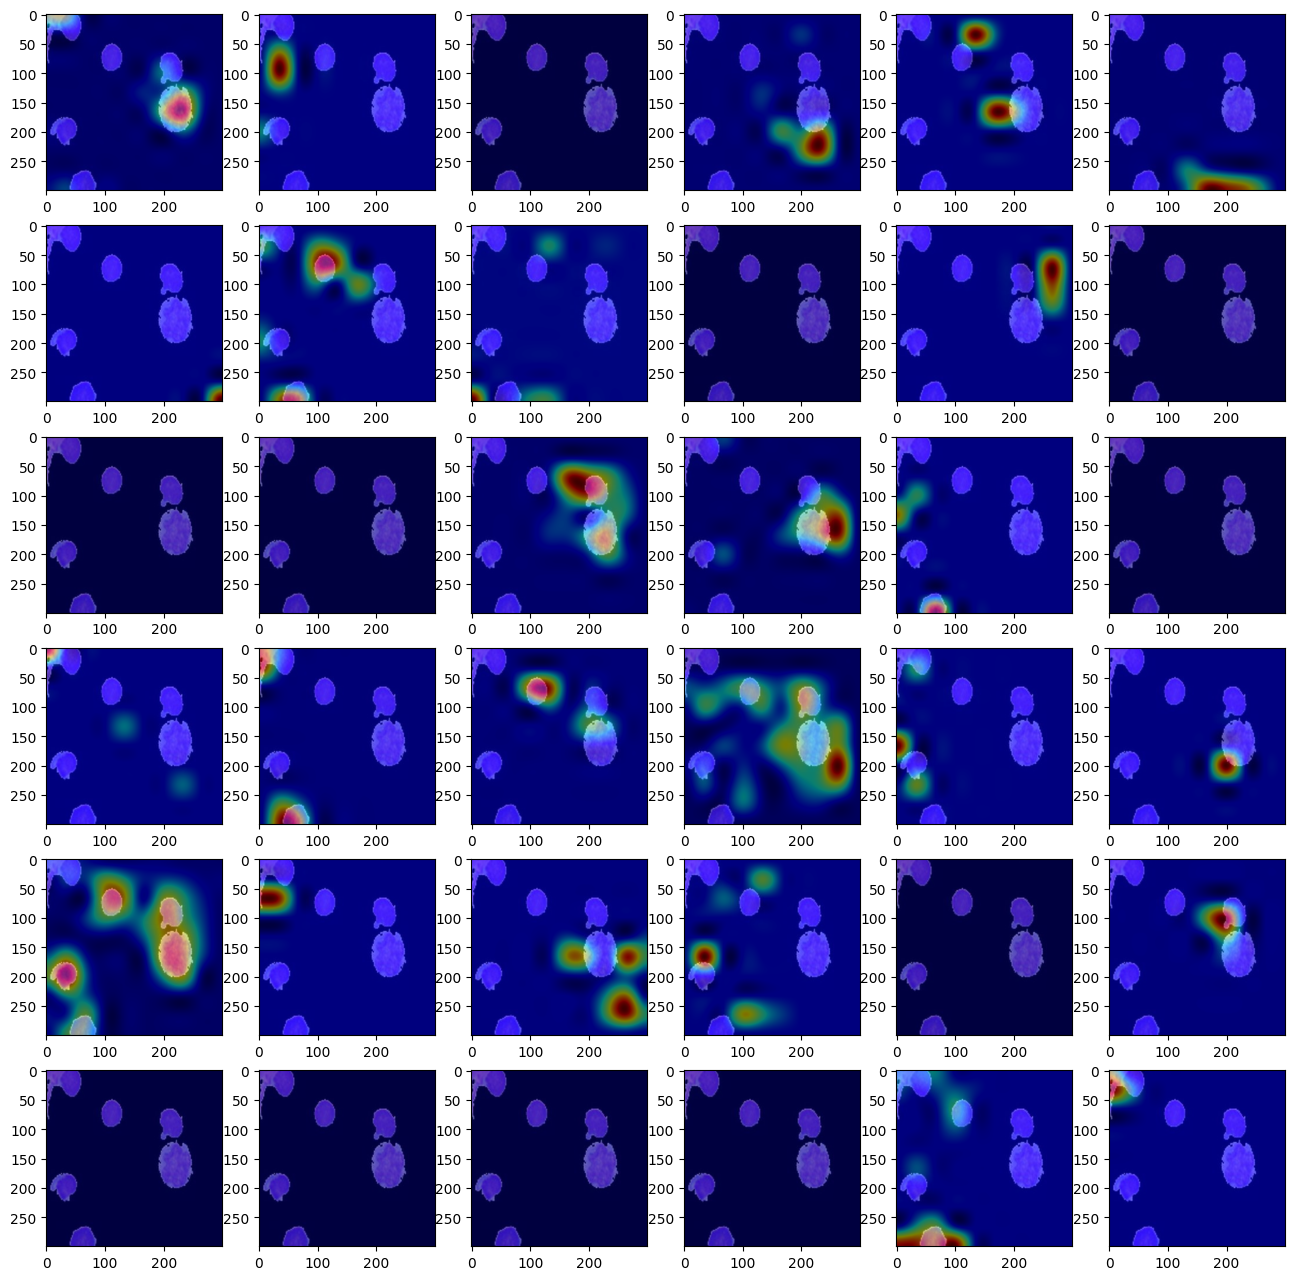

In [220]:
scale = 300/10
plt.figure(figsize=(16, 16))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.imshow(img)
    plt.imshow(zoom(conv[0, :,:,i], zoom=(scale, scale)), cmap='jet', alpha=0.5)

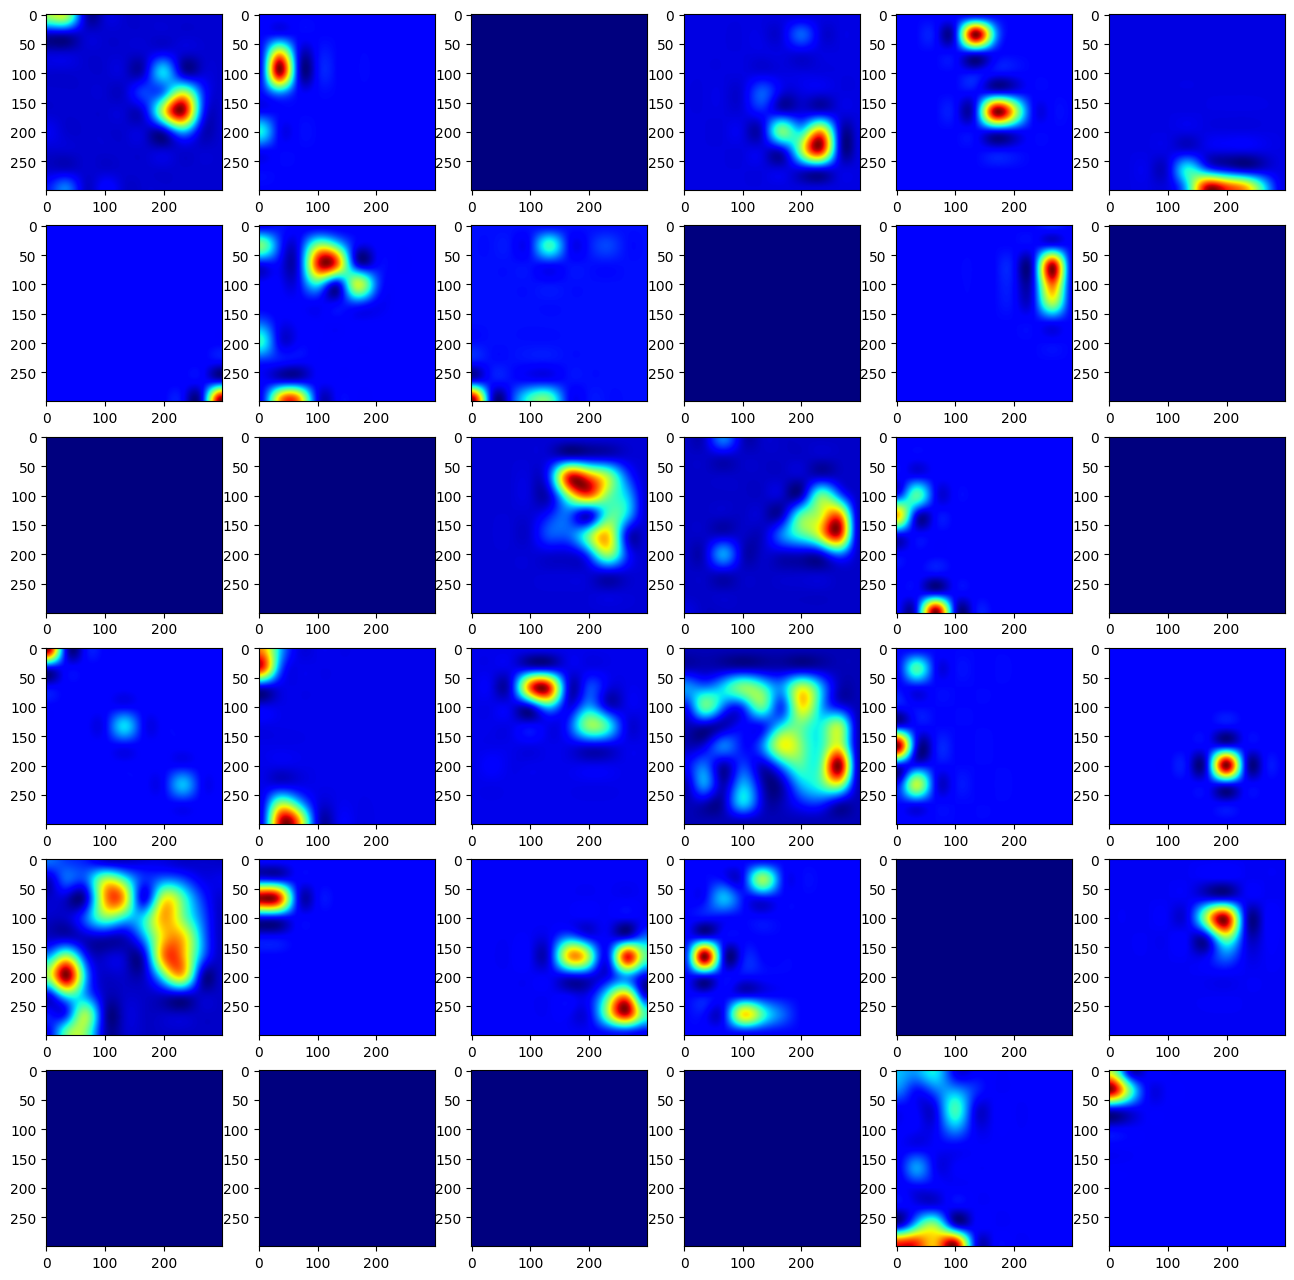

In [221]:
# tanpa gambar asli
scale = 300/10
plt.figure(figsize=(16, 16))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.imshow(zoom(conv[0, :,:,i], zoom=(scale, scale)), cmap='jet', alpha=1)

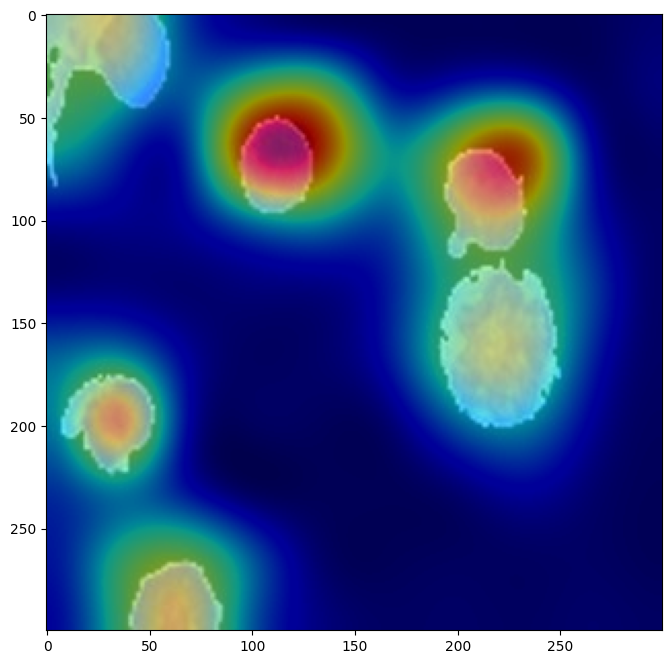

In [222]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

scale = 300/10
combined_activation = np.mean(conv[0], axis=-1)  # Shape: (h, w)
combined_activation_resized = zoom(combined_activation, zoom=(scale, scale))
combined_activation_resized -= combined_activation_resized.min()
combined_activation_resized /= combined_activation_resized.max()
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.imshow(combined_activation_resized, cmap='jet', alpha=0.6) #alpha buat opacitynya
plt.axis()
plt.show()


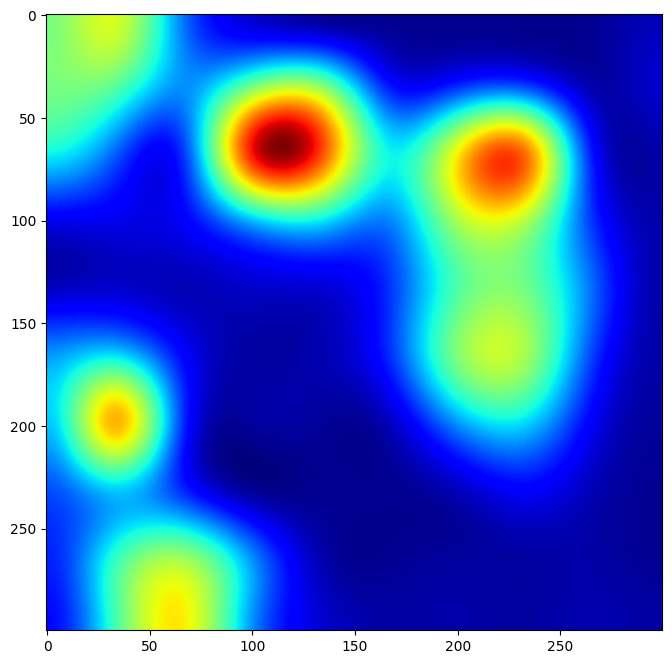

In [223]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

scale = 300/10
combined_activation = np.mean(conv[0], axis=-1)  # Shape: (h, w)
combined_activation_resized = zoom(combined_activation, zoom=(scale, scale))
combined_activation_resized -= combined_activation_resized.min()
combined_activation_resized /= combined_activation_resized.max()
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.imshow(combined_activation_resized, cmap='jet', alpha=1) #alpha buat opacitynya
plt.axis()
plt.show()

early preb heatmap

In [224]:
img = cv2.imread('aaaearlypreb.jpg')
img = cv2.resize(img, (300, 300))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
X = np.expand_dims(img, axis=0).astype(np.float32)
X = preprocess_input(X)

conv, pred = heatmap_model.predict(X)
pred_class_idx = np.argmax(pred, axis=1)[0]
predicted_label = class_labels[pred_class_idx]

print(f"Hasil prediksi class adalah: {predicted_label}")

1/1 [==============================] - 0s 35ms/step
Hasil prediksi class adalah: EarlyPreB


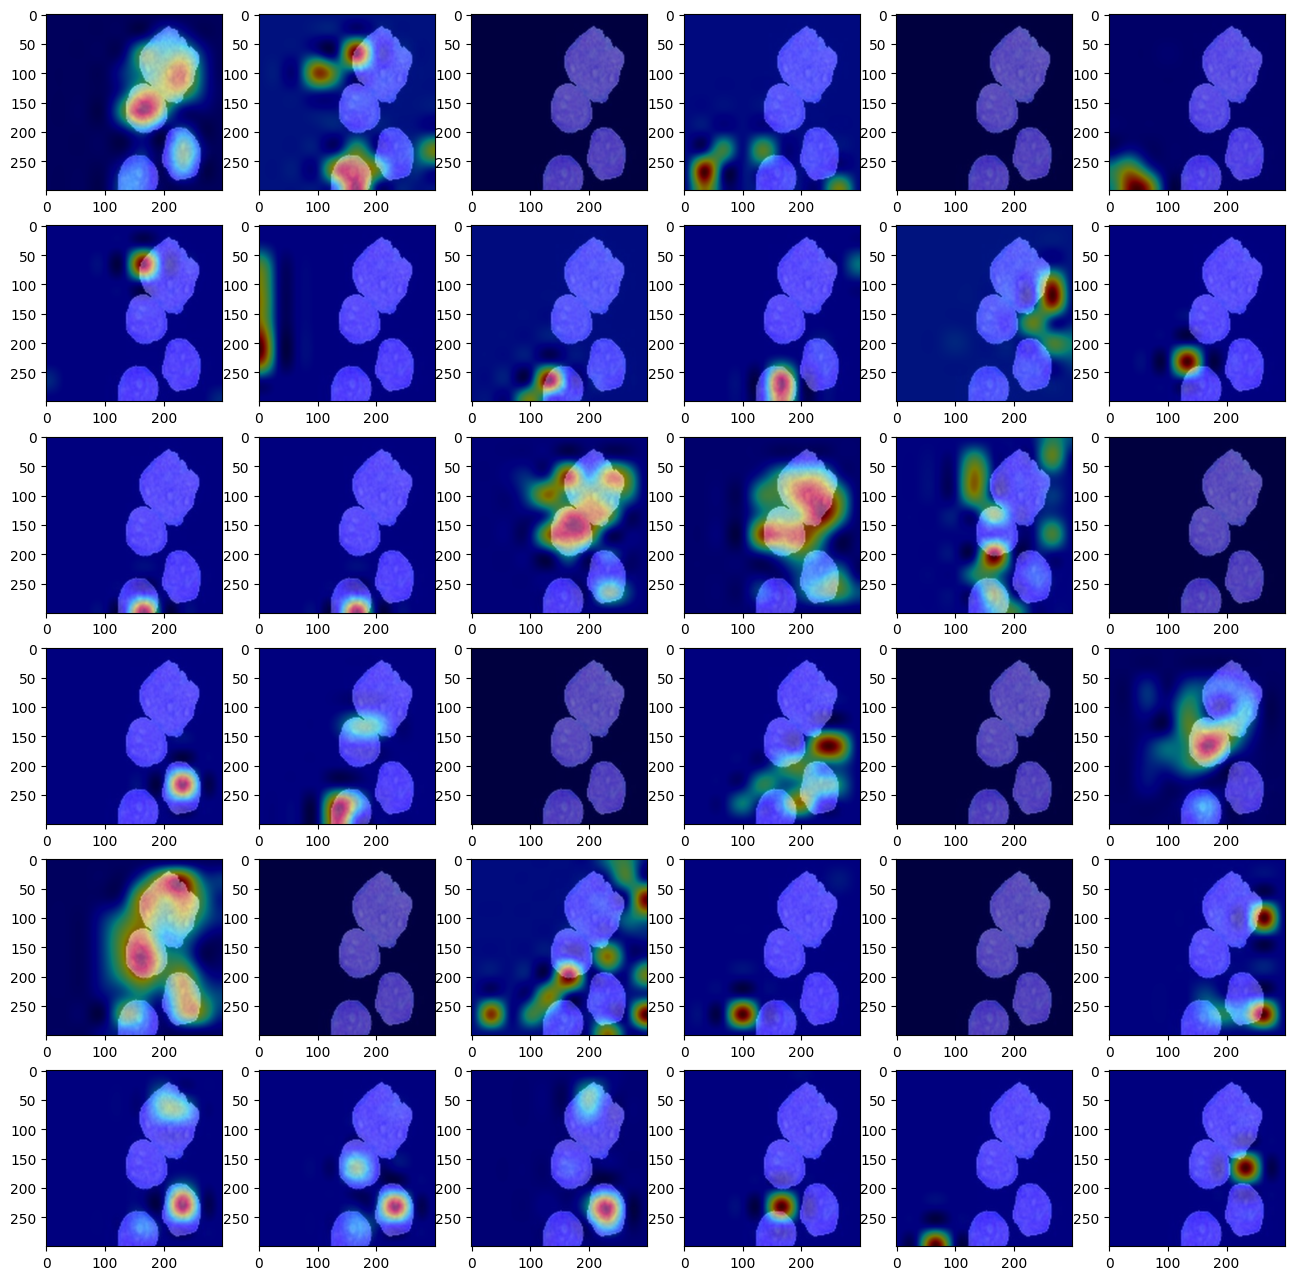

In [225]:
scale = 300/10
plt.figure(figsize=(16, 16))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.imshow(img)
    plt.imshow(zoom(conv[0, :,:,i], zoom=(scale, scale)), cmap='jet', alpha=0.5)

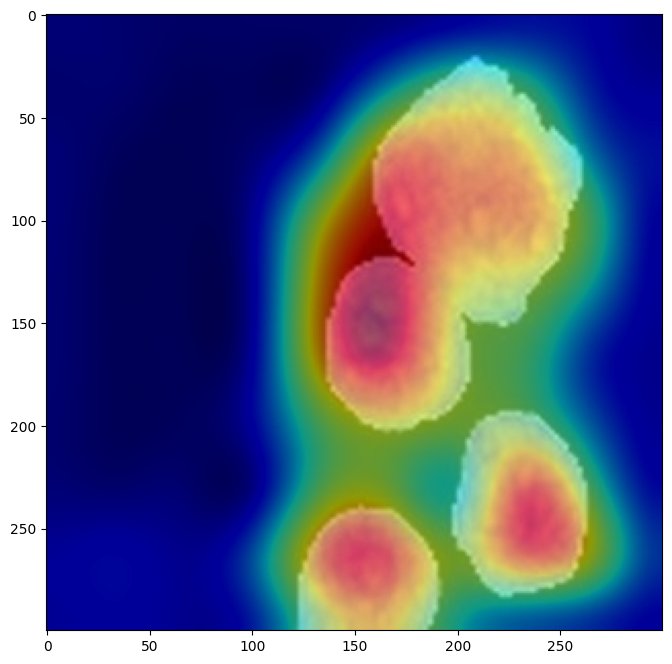

In [226]:
scale = 300/10
combined_activation = np.mean(conv[0], axis=-1)  # Shape: (h, w)
combined_activation_resized = zoom(combined_activation, zoom=(scale, scale))
combined_activation_resized -= combined_activation_resized.min()
combined_activation_resized /= combined_activation_resized.max()
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.imshow(combined_activation_resized, cmap='jet', alpha=0.6) #alpha buat opacitynya
plt.axis()
plt.show()

nyoba heatmap preb

In [227]:
img = cv2.imread('aaapreb.jpg')
img = cv2.resize(img, (300, 300))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
X = np.expand_dims(img, axis=0).astype(np.float32)
X = preprocess_input(X)

conv, pred = heatmap_model.predict(X)
pred_class_idx = np.argmax(pred, axis=1)[0]
predicted_label = class_labels[pred_class_idx]

print(f"Hasil prediksi class adalah: {predicted_label}")

1/1 [==============================] - 0s 32ms/step
Hasil prediksi class adalah: PreB


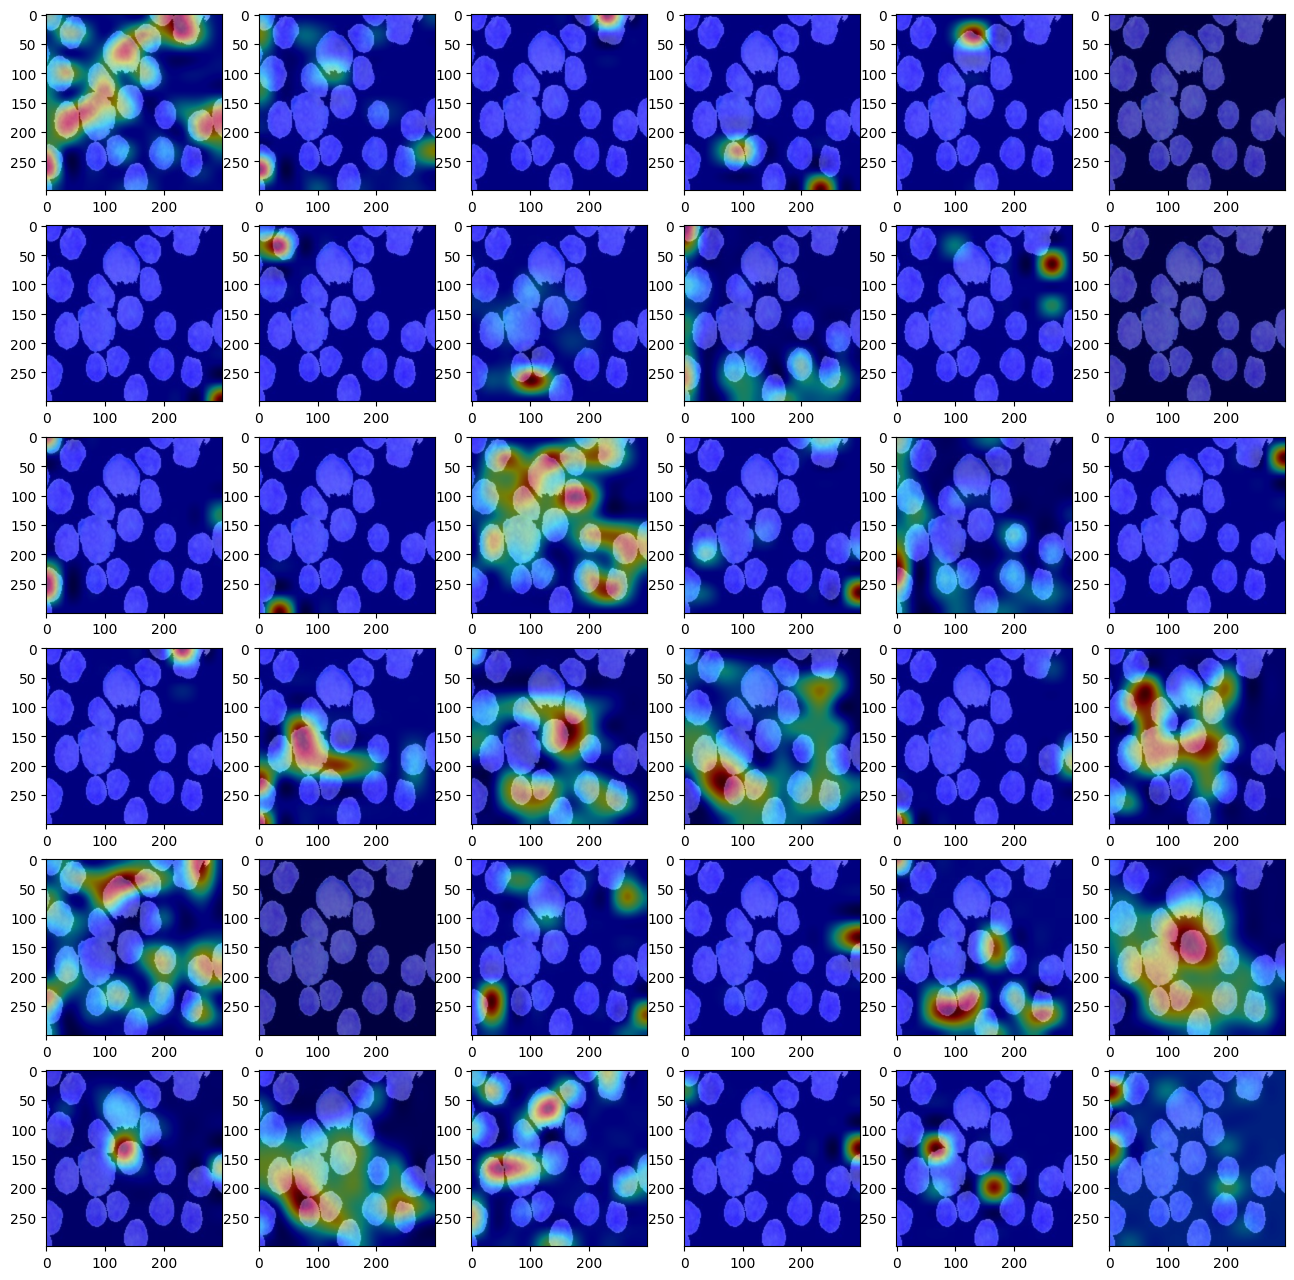

In [228]:
scale = 300/10
plt.figure(figsize=(16, 16))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.imshow(img)
    plt.imshow(zoom(conv[0, :,:,i], zoom=(scale, scale)), cmap='jet', alpha=0.5)

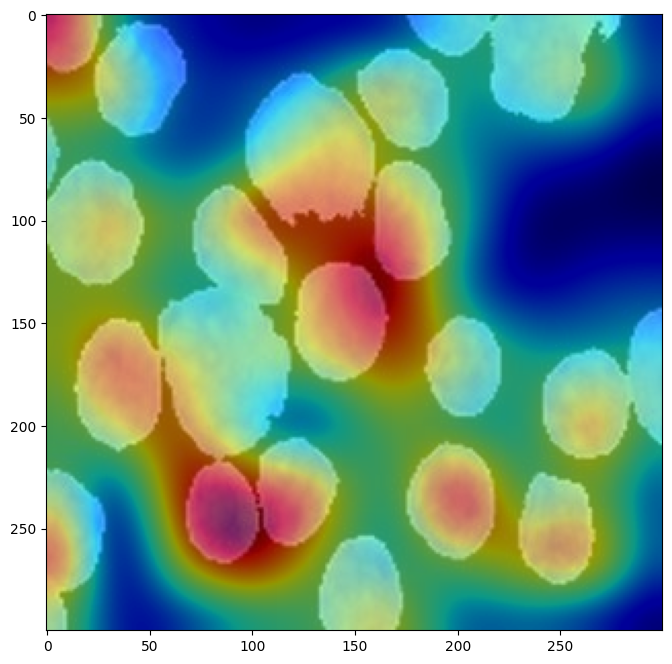

In [229]:
scale = 300/10
combined_activation = np.mean(conv[0], axis=-1)  # Shape: (h, w)
combined_activation_resized = zoom(combined_activation, zoom=(scale, scale))
combined_activation_resized -= combined_activation_resized.min()
combined_activation_resized /= combined_activation_resized.max()
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.imshow(combined_activation_resized, cmap='jet', alpha=0.6) #alpha buat opacitynya
plt.axis()
plt.show()

HEATMAP PROB

In [230]:
img = cv2.imread('aaaprob.jpg')
img = cv2.resize(img, (300, 300))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
X = np.expand_dims(img, axis=0).astype(np.float32)
X = preprocess_input(X)

conv, pred = heatmap_model.predict(X)
pred_class_idx = np.argmax(pred, axis=1)[0]
predicted_label = class_labels[pred_class_idx]

print(f"Hasil prediksi class adalah: {predicted_label}")

1/1 [==============================] - 0s 48ms/step
Hasil prediksi class adalah: ProB


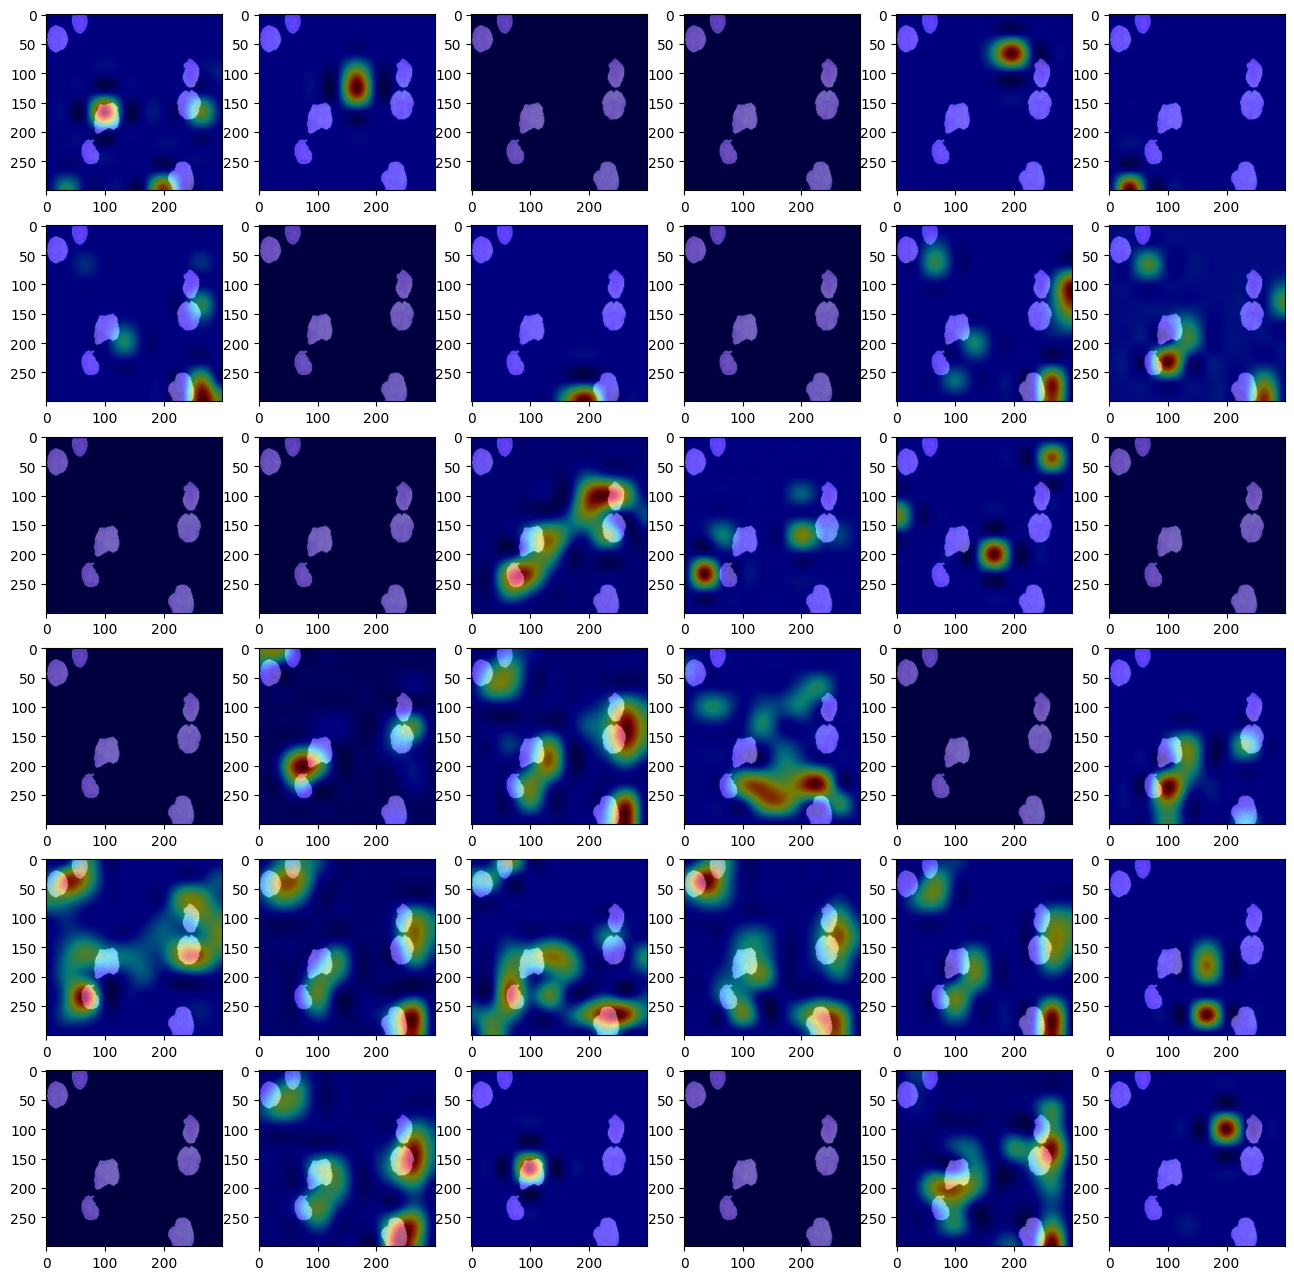

In [231]:
scale = 300/10
plt.figure(figsize=(16, 16))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.imshow(img)
    plt.imshow(zoom(conv[0, :,:,i], zoom=(scale, scale)), cmap='jet', alpha=0.5)

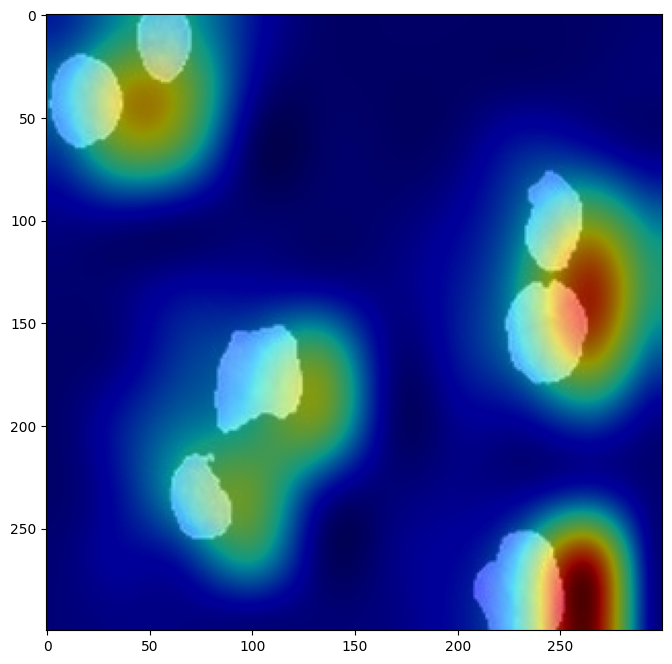

In [232]:
scale = 300/10
combined_activation = np.mean(conv[0], axis=-1)  # Shape: (h, w)
combined_activation_resized = zoom(combined_activation, zoom=(scale, scale))
combined_activation_resized -= combined_activation_resized.min()
combined_activation_resized /= combined_activation_resized.max()
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.imshow(combined_activation_resized, cmap='jet', alpha=0.6) #alpha buat opacitynya
plt.axis()
plt.show()